In [1]:
%reload_ext autoreload
%autoreload

In [2]:
from imagenet_utils import *

Using TensorFlow backend.


In [3]:
import keras.backend as K
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, Activation
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import keras
import pickle
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [4]:
num_class = 50
index_to_label = pickle.load(open('index_to_label.p','rb'))
keep = pickle.load(open('keep.p', 'rb'))
label_to_index = {index_to_label[keep[i]]:i for i in range(len(keep))}
index_to_label = {u:v for v,u in label_to_index.items()}

In [5]:
model = create_net('reduced_weights.h5', num_class)

In [6]:
train_path = 'train_small/'
val_path = 'val_small/'
test_path = 'test_small/'
classes = sorted(os.listdir(train_path))
num_imgs = [len(os.listdir(train_path+classes[c])) for c in range(num_class)]

In [7]:
convLayers = []
for i in range(len(model.layers)):
    if ("mixed" in model.layers[i].name) & (model.layers[i].name[-2] != '_'):
        convLayers.append(model.layers[i])
convBlocks = getBlocks(convLayers)

In [15]:
bs = 100
datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
gen = datagen.flow_from_directory(test_path,target_size=(299,299),class_mode='categorical',shuffle=False,batch_size=bs)

Found 2500 images belonging to 50 classes.


In [16]:
opt = keras.optimizers.Adam(1e-4)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
evaluation = model.evaluate_generator(gen, steps = gen.n // gen.batch_size, verbose = 1)

25/25 [==============================] - 124s 5s/step


In [11]:
evaluation #train

[0.09497267428971827, 0.9776000053882599]

In [14]:
evaluation #val

[0.0903473055921495, 0.981200008392334]

In [17]:
evaluation #test

[0.2648766044899821, 0.9300000023841858]

DATA PREPARATION

In [8]:
rights2 = pickle.load(open('pickles/50Imagenet/rights_cond.p', 'rb'))
wrongs = pickle.load(open('pickles/50Imagenet/wrongs_cond.p', 'rb'))
rights = {}
for c in range(num_class):
    rights[c] = rights2[c]

In [10]:
#to be modified
layers = [len(convLayers)-i-1 for i in range(len(convLayers))]
concat = 0
finalWrongs = process_data(layers, wrongs2, concat)
finalRights = process_data(layers, rights2, concat)

In [11]:
trainD = np.concatenate((finalWrongs, finalRights), axis = 0)
mean = np.mean(trainD, axis = 0)
ma = np.max(trainD, axis = 0)
mi = np.min(trainD, axis = 0)
trainD = (trainD - mean)/(ma-mi)
y_wrongs = np.ones(len(finalWrongs))
y_rights = np.zeros(len(finalRights))
trainL = np.concatenate((y_wrongs, y_rights), axis = 0)

TRAINING

In [12]:
val_cond = pickle.load(open('val_cond.p', 'rb'))
val_index = pickle.load(open('val_index.p', 'rb'))

In [13]:
valD = process_data(layers, val_cond, concat)
valD = (valD-mean)/(ma-mi)

In [16]:
valL = get_labels(val_index, 50, 'val_pred.p', num_class)

In [19]:
verif = create_verif(trainD.shape[1])

In [113]:
roc_call = roc_callback(training_data=(trainD, trainL),validation_data=(valD, valL))
history = verif.fit(trainD, trainL, batch_size = 100, validation_data = (valD, valL), epochs = 1, callbacks = [roc_call])
#plot(history)

Train on 25000 samples, validate on 2500 samples
Epoch 1/1
25000/25000 [==============================] - 2s 84us/step - loss: 0.0496 - val_loss: 0.0534
roc-auc: 0.9849 - roc-auc_val: 0.95876                                                                                                    


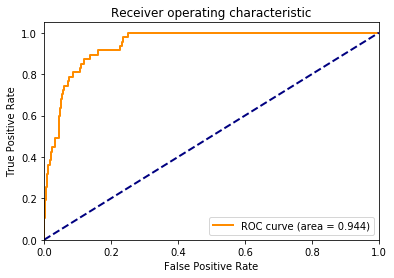

accuracy 0.8732 mean recall 0.8727784475804703 right recall 0.8732164696290257 wrong recall 0.8723404255319149
0.019 0.9440806307517499


In [21]:
val_res = verif.predict(valD)
cond_threshs, cond_ind, cond_auroc = find_opti_thresh(valL, val_res, plot = True)
cond_thresh = cond_threshs[cond_ind-3]
cond_thresh = 1.9e-2
_ = report_acc(val_res, valL, cond_thresh, True)
print(cond_thresh, cond_auroc)

TEST PART

In [22]:
test_cond2 = pickle.load(open('test_cond.p', 'rb')) #calculated with one Grad
test_index = pickle.load(open('test_index.p', 'rb'))

In [23]:
testD = process_data(layers, test_cond2, concat = concat)
testD = (testD-mean)/(ma-mi)

In [26]:
testL = get_labels(test_index, 50, 'test_pred.p', num_class)

In [27]:
test_res = verif.predict(testD)
_ = report_acc(test_res, testL, 0.019, True)

accuracy 0.8244 mean recall 0.8527496159754224 right recall 0.8197849462365592 wrong recall 0.8857142857142857


In [146]:
#verif.save('leading_to_best_nn.h5')

In [20]:
verif.load_weights('leading_to_best_nn.h5')

LCR

In [28]:
LCRW = pickle.load(open('LCRW_NAI_0.002.p', 'rb'))
LCRR = pickle.load(open('LCRR_NAI_0.002.P', 'rb'))
LCR_train = np.concatenate((LCRW, LCRR)).reshape((-1,1))

In [29]:
LCR_val = pickle.load(open('LCR_val_NAI_0.002.p', 'rb')).reshape((-1,1))
LCR_test = pickle.load(open('LCR_test_NAI_0.002.p', 'rb')).reshape((-1,1))

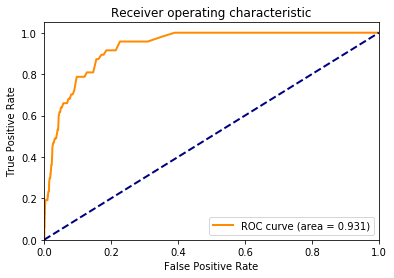

accuracy 0.8444 mean recall 0.8581025405278817 right recall 0.8438646555238484 wrong recall 0.8723404255319149
0.151 0.9311221170776557


In [30]:
lcr_threshs, lcr_ind, lcr_auroc = find_opti_thresh(valL, LCR_val, plot = True)
lcr_thresh = lcr_threshs[lcr_ind-6]
lcr_thresh = 0.151
_ = report_acc(LCR_val, valL, lcr_thresh, True)
print(lcr_thresh, lcr_auroc)

In [31]:
_ = report_acc(LCR_test, testL, lcr_thresh, True)

accuracy 0.8252 mean recall 0.879600614439324 right recall 0.8163440860215053 wrong recall 0.9428571428571428


LCR AND CONDUCTANCE

In [32]:
train_res = verif.predict(trainD)
data = np.concatenate((LCR_train.reshape((-1,1)), train_res), axis = 1)
data_val = np.concatenate((LCR_val.reshape((-1,1)), val_res), axis = 1)
data_test = np.concatenate((LCR_test.reshape((-1,1)), test_res), axis = 1)

In [33]:
nn = Sequential()    
nn.add(Dense(10, input_shape = (data.shape[1],), activation = 'relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation = 'sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
nn.compile(loss = 'binary_crossentropy', optimizer=opt,metrics=None)

In [104]:
roc_call = roc_callback(training_data=(data, trainL),validation_data=(data_val, valL))
history = nn.fit(data, trainL, validation_data = (data_val, valL), batch_size = 100, epochs = 1, callbacks = [roc_call])

Train on 25000 samples, validate on 2500 samples
Epoch 1/1
25000/25000 [==============================] - 1s 55us/step - loss: 0.0941 - val_loss: 0.0620
roc-auc: 0.97562 - roc-auc_val: 0.9574                                                                                                    


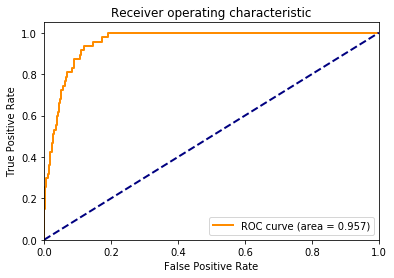

accuracy 0.8912 mean recall 0.8923853553182816 right recall 0.8911536893599674 wrong recall 0.8936170212765957
0.009 0.9574034399909794


In [35]:
nn_val_res = nn.predict(data_val)
both_threshs, both_ind, both_auroc = find_opti_thresh(valL, nn_val_res, plot = True)
both_thresh = both_threshs[both_ind-3]
both_thresh = 9.00e-3
_ = report_acc(nn_val_res, valL, both_thresh, True)
print(both_thresh, both_auroc)

In [36]:
nn_test_res = nn.predict(data_test)
_ = report_acc(nn_test_res, testL, 0.009, True)

accuracy 0.85 mean recall 0.9008602150537635 right recall 0.8417204301075268 wrong recall 0.96


In [47]:
#nn.save('best_50_class_nn.h5')

In [34]:
nn.load_weights('best_50_class_nn.h5')

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
cond_fpr, cond_tpr, cond_threshs = roc_curve(valL, val_res)
lcr_fpr, lcr_tpr, lcr_threshs = roc_curve(valL, LCR_val)
both_fpr, both_tpr, both_threshs = roc_curve(valL, nn_val_res)

In [38]:
both_x, both_y = both_fpr[both_ind-3], both_tpr[both_ind-3]
lcr_x, lcr_y = lcr_fpr[lcr_ind-6], lcr_tpr[lcr_ind-6]
cond_x, cond_y = cond_fpr[cond_ind-3], cond_tpr[cond_ind-3]

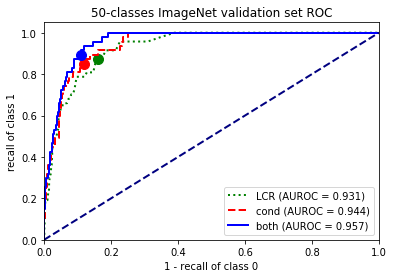

In [39]:
plt.figure()
lw = 2
plt.plot(lcr_fpr, lcr_tpr, ':', color = 'green',
         lw=lw, label='LCR (AUROC = %0.3f)' % lcr_auroc)
plt.plot(lcr_x, lcr_y,marker='o',  markersize=10, color= 'green')
plt.plot(cond_fpr, cond_tpr, '--', color = 'red',
         lw=lw, label='cond (AUROC = %0.3f)' % cond_auroc)
plt.plot(cond_x, cond_y, marker='o',  markersize=10, color= 'red')
plt.plot(both_fpr, both_tpr, color = 'blue',
         lw=lw, label='both (AUROC = %0.3f)' % both_auroc)
plt.plot(both_x, both_y, marker='o',  markersize=10, color= 'blue')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - recall of class 0')
plt.ylabel('recall of class 1')
plt.title('50-classes ImageNet validation set ROC')
plt.legend(loc="lower right")
plt.savefig('50Imagenet_roc.pdf', bbox_inches = 'tight')

In [ ]:
def plot_version(LCR):
    LCR_plot = []
    rnds_pos = np.arange(0,0.05,0.0001)
    rnds = np.concatenate((rnds_pos,-1*rnds_pos))
    for i in range(len(LCR)):
        if LCR[i] < 0.05:
            pert = np.random.choice(rnds_pos)
            LCR_plot.append(LCR[i]+pert)
        else:
            pert = np.random.choice(rnds)
            LCR_plot.append(LCR[i]+pert)
    return LCR_plot

In [ ]:
fig, ax = plt.subplots(figsize = (30,30))
#ax.set(xscale = 'log', yscale = 'log')
ax.set_xlabel('LCR')
ax.set_ylabel('conductance')
#sns.scatterplot(LCR[L], train_res.squeeze(1), hue = valL, ax = ax)
g = sns.scatterplot(plot_version(LCR_val), val_res.squeeze(1), hue = valL, ax = ax)

In [151]:
#random forrest
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth=10 ,random_state=0)
clf_RF.fit(data, trainL)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

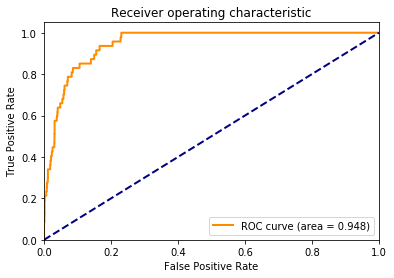

0.00544 0.9478840499258399
accuracy 0.8604 mean recall 0.8662558222237642 right recall 0.8601712189156135 wrong recall 0.8723404255319149


In [257]:
rf_val_res = clf_RF.predict_proba(data_val)[:,1]
threshs,ind, auroc = find_opti_thresh(valL, rf_val_res, plot = True)
thresh = threshs[ind-18]
thresh = 0.00544
print(thresh, auroc)
_ = report_acc(rf_val_res, valL, thresh, True)

In [258]:
rf_test_res = clf_RF.predict_proba(data_test)[:,1]
_ = report_acc(rf_test_res, testL, thresh, True)

accuracy 0.8192 mean recall 0.8763748079877112 right recall 0.8098924731182796 wrong recall 0.9428571428571428


In [260]:
#LDA & QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf_LDA = LDA()
clf_QDA = QDA()
clf_LDA.fit(data, trainL)
clf_QDA.fit(data, trainL)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

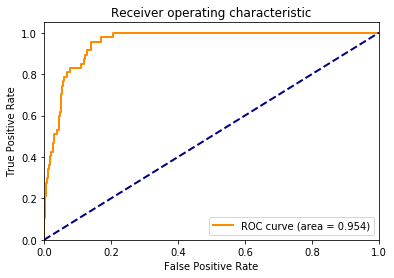

3.81e-07 0.953786505451423
accuracy 0.8772 mean recall 0.874816768004441 right recall 0.877293110476967 wrong recall 0.8723404255319149


In [268]:
LDA_val_res = clf_LDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, LDA_val_res, plot = True)
thresh = threshs[ind-6]
thresh = 3.81e-7
print(thresh, auroc)
_ = report_acc(LDA_val_res, valL, thresh, True)

In [269]:
LDA_test_res = clf_LDA.predict_proba(data_test)[:,1]
_ = report_acc(LDA_test_res, testL, thresh, True)

accuracy 0.8404 mean recall 0.8904147465437788 right recall 0.832258064516129 wrong recall 0.9485714285714286


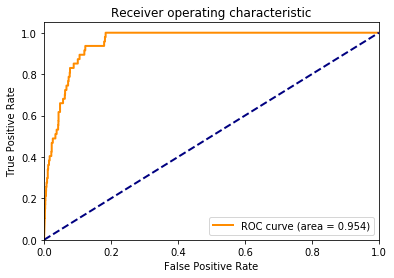

0.0049 <function auc at 0x000002E67E1F28C8>
accuracy 0.8932 mean recall 0.8934045155302669 right recall 0.8931920097839381 wrong recall 0.8936170212765957


In [308]:
QDA_val_res = clf_QDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, QDA_val_res, plot = True)
thresh = threshs[ind-9]
thresh = 4.9e-3
print(thresh, auc)
_ = report_acc(QDA_val_res, valL, thresh, True)

In [309]:
QDA_test_res = clf_QDA.predict_proba(data_test)[:,1]
_ = report_acc(QDA_test_res, testL, thresh, True)

accuracy 0.8584 mean recall 0.8948079877112135 right recall 0.8524731182795698 wrong recall 0.9371428571428572
